#**LDA Topic Modelling and Experiments**

#### Importing required libraries

In [ ]:
import gensim

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.


In [ ]:
!pip install gensim

In [ ]:
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.models import TfidfModel
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramAssocMeasures, TrigramCollocationFinder, QuadgramAssocMeasures, QuadgramCollocationFinder
from nltk import word_tokenize
import matplotlib.pyplot as plt

In [ ]:
nltk.download('words')
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### **N-grams, TF-IDF, LDA** (and more pre-processing)

In [ ]:
class topic_modeling:
    def __init__(self, facts):
        self.facts = facts

    # Function that transforms each fact into a list of unigram words
    def organise(self):
        facts_words = []
        for fact in self.facts:
            split_fact = fact.split()
            facts_words.append(split_fact)
        return facts_words

    # More pre-processing (also in docuemnt clustering) to remove non english and 3 letter words
    def remove_lang_words(self,facts_words, english_words):

      # Filtering out non-english words and three letter words
      filtered = [word for word in facts_words if word in english_words and len(word)>3]
      return filtered

    # bigrams with NLTK for bigram experiment
    def find_bigrams(self, facts):
      text = ' '.join(facts)
      tokens = word_tokenize(text)
      bigrams = list(nltk.bigrams(tokens))
      return bigrams

    # This function can be called if you want to view the tf-idf frequency for each word
    def view_frequencies(self, id2word, texts, corpus, tfidf):
      word_frequency = []
      for doc in corpus:
          # tf-idf representation
          tfidf_vector = tfidf[doc]

          # Iterate over the tf-idf values for each word in the document
          for word_id, tfidf_score in tfidf_vector:
              word = id2word[word_id]
              #append word and its score
              word_frequency.append([word,tfidf_score])

      df_freq = pd.DataFrame(word_frequency, columns = ['Word', 'Frequency'])
      df_sorted = df_freq.sort_values('Frequency', ascending=False)

      return df_sorted

    # This function filters out words that have either a too low or too high tfidf score, in order to avoid words that might be considered stop words
    # This function was inspired by the explanations of:
    #https://github.com/wjbmattingly/topic_modeling_textbook/blob/main/03_03_lda_model_demo_bigrams_trigrams.ipynb
    #https://stackoverflow.com/questions/24688116/how-to-filter-out-words-with-low-tf-idf-in-a-corpus-with-gensim/35951190 (also used by the previous link)
    #video: https://www.youtube.com/watch?v=TKjjlp5_r7o
    def filter_tf_idf(self, id2word, texts, corpus, tfidf):

        # define a lower and upper bound
        low_value = 0.03
        high_value = 0.6
        words = []
        words_missing_in_tfidf = []
        for i in range(0, len(corpus)):
            bow = corpus[i]
            value_words = []
            tfidf_ids = [id for id, value in tfidf[bow]]
            bow_ids = [id for id, value in bow]
            value_words = [id for id, value in tfidf[bow] if value < low_value or value > high_value]
            drops = value_words + words_missing_in_tfidf

            for item in drops:
                words.append(id2word[item])
            words_missing_in_tfidf = [id for id in bow_ids if
                                      id not in tfidf_ids]

            new_bow = [b for b in bow if b[0] not in value_words and b[0] not in words_missing_in_tfidf]
            corpus[i] = new_bow

        return corpus, id2word

    def perform_lda(self, corpus, id2word, topics):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics= topics,
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=50,
                                                    passes=10,
                                                    alpha="auto")

        return lda_model

    # For the coherence score experiment
    def coherence_score(self, corpus, id2word, final_data, limit, step):
      # for every model, keep track on coherence score
      coherence_values = []
      model_list = []
      for topics in range(2, limit, step):
        lda_model = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topics,
                                           random_state=100,
                                           chunksize=50,
                                           passes=10,
                                           alpha="auto")
        coherence_model_lda = CoherenceModel(model=lda_model, texts=final_data, dictionary=id2word, coherence='c_v')
        model_list.append(lda_model)
        coherence_values.append(coherence_model_lda.get_coherence())

      return model_list, coherence_values


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Importing facts

In [ ]:
from google.colab import files
import io

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Violation Facts

In [ ]:
uploaded = files.upload()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving violation_facts_lemma.csv to violation_facts_lemma.csv
Saving violation_facts_none.csv to violation_facts_none.csv
Saving violation_facts_processed.csv to violation_facts_processed.csv
Saving violation_facts_sw.csv to violation_facts_sw.csv


In [ ]:
violation_processed = pd.read_csv(io.BytesIO(uploaded['violation_facts_processed.csv']))
violation_lemma = pd.read_csv(io.BytesIO(uploaded['violation_facts_lemma.csv']))
violation_sw = pd.read_csv(io.BytesIO(uploaded['violation_facts_sw.csv']))
violation_none = pd.read_csv(io.BytesIO(uploaded['violation_facts_none.csv']))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Non Violation

In [ ]:
nv_uploaded = files.upload()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving non_violation_facts_lemma.csv to non_violation_facts_lemma.csv
Saving non_violation_facts_none.csv to non_violation_facts_none.csv
Saving non_violation_facts_processed.csv to non_violation_facts_processed.csv
Saving non_violation_facts_sw.csv to non_violation_facts_sw.csv


In [ ]:
nv_processed = pd.read_csv(io.BytesIO(nv_uploaded['non_violation_facts_processed.csv']))
nv_lemma = pd.read_csv(io.BytesIO(nv_uploaded['non_violation_facts_lemma.csv']))
nv_sw = pd.read_csv(io.BytesIO(nv_uploaded['non_violation_facts_sw.csv']))
nv_none = pd.read_csv(io.BytesIO(nv_uploaded['non_violation_facts_none.csv']))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Some more pre-processing

In [ ]:
violation_tm = violation_none
violation_tm.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,Facts,Cluster,x0,x1
0,0,in and lives in warsaw he was represented by m...,NaN,NaN,NaN
1,1,the applicant was born in he is serving a life...,NaN,NaN,NaN
2,2,the applicant was born in and lives in glina a...,NaN,NaN,NaN
3,3,born in and is detained in istanbul he was rep...,NaN,NaN,NaN
4,4,the proceedings at issue the applicant was bor...,NaN,NaN,NaN


In [ ]:
# Splitting into a list of lists of words
facts = violation_tm['Facts'].tolist()
tm = topic_modeling(facts)
facts_words = tm.organise()
print(len(facts_words))

207


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Removing non english words
final_data = []
english_words = set(nltk.corpus.words.words())
for i in range(0, len(facts_words)):
  facts_words_filtered = tm.remove_lang_words(facts_words[i], english_words)
  final_data.append(facts_words_filtered)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(final_data[0])

['warsaw', 'warsaw', 'polish', 'agent', 'ministry', 'foreign', 'lodged', 'behalf', 'client', 'company', 'formal', 'notification', 'crime', 'following', 'statement', 'data', 'sufficiently', 'justify', 'suspicion', 'full', 'name', 'service', 'bribe', 'taking', 'bribe', 'unknown', 'probably', 'company', 'name', 'code', 'document', 'question', 'connection', 'investigation', 'forging', 'detriment', 'client', 'ongoing', 'time', 'particular', 'course', 'investigation', 'promptly', 'overall', 'investigation', 'question', 'prematurely', 'unjustifiably', 'grounds', 'insufficient', 'justify', 'suspicion', 'crime', 'expert', 'view', 'explanation', 'irrational', 'discontinue', 'investigation', 'charge', 'investigation', 'question', 'notification', 'contain', 'regarding', 'allegedly', 'bribe', 'name', 'company', 'supposedly', 'employed', 'warsaw', 'district', 'open', 'inquiry', 'reasoning', 'stated', 'single', 'piece', 'factual', 'circumstance', 'bribery', 'interlocutory', 'lodged', 'warsaw', 'regio

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Creating bigrams

In [ ]:
bigram_list = []
for data in final_data:
  bigrams = tm.find_bigrams(data)
  bigram_list.append(bigrams)

print(bigram_list[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('life', 'relevant'), ('relevant', 'time'), ('time', 'journalist'), ('journalist', 'weekly'), ('weekly', 'news'), ('news', 'magazine'), ('magazine', 'based'), ('based', 'town'), ('town', 'agent'), ('agent', 'party'), ('party', 'titled'), ('titled', 'shame'), ('shame', 'silence'), ('silence', 'piece'), ('piece', 'written'), ('written', 'relevant'), ('relevant', 'reason'), ('reason', 'ashamed'), ('ashamed', 'towards'), ('towards', 'head'), ('head', 'municipal'), ('municipal', 'branch'), ('branch', 'office'), ('office', 'firstly'), ('firstly', 'city'), ('city', 'front'), ('front', 'main'), ('main', 'post'), ('post', 'office'), ('office', 'building'), ('building', 'falsely'), ('falsely', 'street'), ('street', 'vendor'), ('vendor', 'market'), ('market', 'inspector'), ('inspector', 'pretext'), ('pretext', 'certain'), ('certain', 'document'), ('document', 'copied'), ('copied', 'thereafter'), ('thereafter', 'drove'), ('drove', 'girl'), ('girl', 'away'), ('away', 'street'), ('street', 'tried')

In [ ]:
# Because the NLTK bigrams are outputted as lists of tuples, this piece of code is to format the bigrams with the classic representation "word1_word2"
combined_tuples = []
final_bigram_list = []
for bigrams in bigram_list:
  combined_tuples = []
  for tuples in bigrams:
    combined = '_'.join(tuples)
    combined_tuples.append(combined)
  final_bigram_list.append(combined_tuples)
print(final_bigram_list[1])
final_data = final_bigram_list

['born_life', 'life_campaigner', 'campaigner_abortion', 'abortion_distributed', 'distributed_leaflet', 'leaflet_immediate', 'immediate_vicinity', 'vicinity_medical', 'medical_practice', 'practice_leaflet', 'leaflet_inter', 'inter_following', 'following_text', 'text_front', 'front_page', 'page_know', 'know_full', 'full_name', 'name_address', 'address_abortion', 'abortion_unlawful', 'unlawful_according', 'according_federal', 'federal_constitutional', 'constitutional_nach', 'nach_sind', 'sind_underneath', 'underneath_following', 'following_smaller', 'smaller_type', 'type_according', 'according_international', 'international_murder', 'murder_intentional', 'intentional_innocent', 'innocent_tode', 'tode_back', 'back_side', 'side_folded', 'folded_leaflet', 'leaflet_following', 'following_text', 'text_murder', 'murder_unlawful', 'unlawful_morally', 'morally_degraded', 'degraded_state', 'state_murder', 'murder_innocent', 'innocent_people', 'people_make', 'make_subject', 'subject_liability', 'li

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### TFIDF and LDA
Visualising the words and their tf-idf score (This was more for debugging)

In [ ]:
id2word = corpora.Dictionary(final_data)
texts = final_data
corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus, id2word=id2word)

df_sorted = tm.view_frequencies(id2word, texts, corpus, tfidf)
df_sorted

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Word,Frequency
39011,blocking,0.924174
73831,reception,0.911324
19616,blocking,0.882827
177215,jury,0.882304
153739,mesopotamia,0.879975
...,...,...
185937,notified,0.000009
135679,notified,0.000008
135522,done,0.000008
36333,done,0.000007


In [ ]:
corpus_filter, id2word_filter = tm.filter_tf_idf(id2word, texts, corpus, tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Coherence Score (Experiment) to find out optimal number of clusters

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


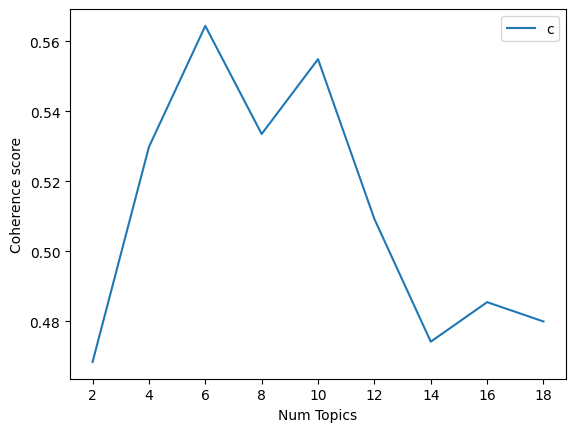

In [ ]:
model_list, coherence_values = tm.coherence_score(corpus_filter, id2word_filter, final_data, 20, 2)
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
lda_model = tm.perform_lda(corpus_filter, id2word_filter, 6)
coherence_model = CoherenceModel(model=lda_model, texts=final_data, dictionary=id2word_filter, coherence='c_v')
print(coherence_model.get_coherence())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5643848936966742


## pyLDAvis Visualisation for each preprocessing technique

Processed

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_filter, id2word_filter, mds="mmds", R=30)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.126352 -0.124462       1        1  10.787873
2     -0.116590 -0.245639       2        1  10.263852
0      0.131982  0.354914       3        1   9.674624
3     -0.129106  0.081602       4        1   9.436855
8     -0.361694  0.128369       5        1   8.733308
5     -0.266561 -0.275446       6        1   8.131361
13     0.046804 -0.349150       7        1   7.328998
1      0.293379 -0.308826       8        1   7.239468
7      0.385571 -0.023754       9        1   6.818054
11     0.321749  0.198668      10        1   5.772514
10    -0.347730 -0.061988      11        1   5.517173
9      0.127904  0.070427      12        1   4.200505
12    -0.203741  0.301268      13        1   3.217427
6     -0.008319  0.254017      14        1   2.877987, topic_info=             Term        Freq       Total Category  logprob  loglift
1135      company  754.000000  754.000000  Default  30.0000  30.0000
111       comment  268.000000  268.000000  Default  29.0000  29.0000
1178         data  396.000000  396.000000  Default  28.0000  28.0000
183    disclosure  216.000000  216.000000  Default  27.0000  27.0000
378    journalist  348.000000  348.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
522     plaintiff    9.485994   74.918582  Topic14  -4.8207   1.4815
645        second    9.243028   93.967963  Topic14  -4.8467   1.2290
716     suspicion    7.793528   37.856889  Topic14  -5.0172   1.9676
162    defamation    7.171971  170.113621  Topic14  -5.1004   0.3818
573   publication    7.056755  299.972513  Topic14  -5.1166  -0.2016

[747 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2         2  0.145056     abuse
2        10  0.314288     abuse
2        13  0.024176     abuse
2        14  0.507696     abuse
1025      1  0.006128    access
...     ...       ...       ...
1679      7  0.943238      work
803       6  0.952015   working
806       3  0.954054   written
1929     10  0.965266  wrongful
2875     11  0.932863      zone

[1186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 4, 9, 6, 14, 2, 8, 12, 11, 10, 13, 7])

Lemmatized

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_filter, id2word_filter, mds="mmds", R=30)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.335338  0.082195       1        1  12.741033
3     -0.208052  0.243473       2        1  12.473146
0      0.028564 -0.358660       3        1  11.250706
9     -0.025017  0.385423       4        1  10.020054
8      0.094846  0.046132       5        1   9.888740
2     -0.314603 -0.154385       6        1   7.747061
1      0.358219  0.146788       7        1   7.707757
11     0.239990 -0.085956       8        1   6.600863
5     -0.105494 -0.003999       9        1   6.285171
4      0.246256 -0.281339      10        1   6.114039
10     0.181283  0.264975      11        1   4.625698
6     -0.160654 -0.284647      12        1   4.545732, topic_info=             Term        Freq       Total Category  logprob  loglift
1244      company  746.000000  746.000000  Default  30.0000  30.0000
1288         data  389.000000  389.000000  Default  29.0000  29.0000
586        police  321.000000  321.000000  Default  28.0000  28.0000
423         judge  700.000000  700.000000  Default  27.0000  27.0000
3342       search  177.000000  177.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1274      council   20.978594  148.731073  Topic12  -4.5784   1.1323
638   publication   21.177644  288.962251  Topic12  -4.5690   0.4776
4612    dismissal   15.114850   82.939031  Topic12  -4.9063   1.3886
611       privacy   12.452540   43.623998  Topic12  -5.1000   1.8373
3018     claimant   12.831870   76.823758  Topic12  -5.0700   1.3014

[700 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         2  0.252602      abuse
4         7  0.732544      abuse
1133      3  0.153031     access
1133      4  0.623053     access
1133      5  0.058297     access
...     ...       ...        ...
901       3  0.180933    witness
901      10  0.474948    witness
902       2  0.935067       word
3113      6  0.904566  workplace
3002      7  0.973549       zone

[1181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 1, 10, 9, 3, 2, 12, 6, 5, 11, 7])

Only Stop Word Removal

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_filter, id2word_filter, mds="mmds", R=30)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.108086 -0.066735       1        1  19.900101
4      0.139679  0.029373       2        1  17.167719
9     -0.081070  0.093616       3        1  16.256832
1      0.030547 -0.088146       4        1  10.366192
7      0.039700 -0.025010       5        1   8.065765
0      0.033656  0.047580       6        1   7.707722
5     -0.010677  0.047378       7        1   6.884769
8     -0.000810 -0.017846       8        1   6.508481
2     -0.041399 -0.020343       9        1   6.272155
3     -0.001540  0.000133      10        1   0.870264, topic_info=                           Term       Freq      Total Category  logprob  \
9422              personal_data  48.000000  48.000000  Default  30.0000   
2510         access_information  50.000000  50.000000  Default  29.0000   
3716                hate_speech  40.000000  40.000000  Default  28.0000   
4830           radio_television  18.000000  18.000000  Default  27.0000   
22139             search_engine  24.000000  24.000000  Default  26.0000   
...                         ...        ...        ...      ...      ...   
3863          information_shall   0.048145   1.111283  Topic10  -8.5444   
61406              upon_receipt   0.048145   1.443987  Topic10  -8.5444   
2510         access_information   0.056852  50.592288  Topic10  -8.3781   
12338  significant_disadvantage   0.043772   7.510733  Topic10  -8.6396   
6044         interference_first   0.032928   0.615091  Topic10  -8.9243   

       loglift  
9422   30.0000  
2510   29.0000  
3716   28.0000  
4830   27.0000  
22139  26.0000  
...        ...  
3863    1.6051  
61406   1.3432  
2510   -2.0470  
12338  -0.4010  
6044    1.8167  

[395 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
79656      4  0.899228           abuse_trust
5          2  0.946759  acceptable_criticism
2510       1  0.889464    access_information
2510       3  0.079063    access_information
2510       5  0.019766    access_information
...      ...       ...                   ...
95471      5  0.805428          whose_source
2475       7  0.796650        within_context
76724      5  1.157473     without_knowledge
7472       4  1.086600        without_notice
29230      6  1.098097          would_longer

[388 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 10, 2, 8, 1, 6, 9, 3, 4])

No Pre-processing

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_filter, id2word_filter, mds="mmds", R=30)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.321715  0.318449       1        1  6.260844
16     0.094101  0.334276       2        1  5.901307
17    -0.016898  0.364510       3        1  5.641060
10    -0.158038  0.400667       4        1  5.205105
23     0.441075 -0.086404       5        1  4.893736
5      0.291432 -0.013236       6        1  4.773972
11     0.114615  0.428965       7        1  4.411182
4     -0.350372 -0.187821       8        1  3.623145
33    -0.367893  0.072692       9        1  3.428704
18     0.222692  0.222905      10        1  3.380922
7      0.366160  0.163889      11        1  3.210971
31    -0.038336  0.216222      12        1  3.180518
27    -0.419528 -0.080341      13        1  3.005607
19    -0.177861  0.192898      14        1  2.954362
22    -0.076665 -0.449371      15        1  2.816387
9     -0.293405  0.321944      16        1  2.814551
28    -0.373359  0.183692      17        1  2.673860
14    -0.215735  0.069199      18        1  2.525069
15     0.063228  0.116802      19        1  2.427554
32     0.380801  0.058620      20        1  2.378871
8     -0.299882 -0.091362      21        1  2.275733
6      0.188945 -0.279608      22        1  2.209961
21     0.149120 -0.007760      23        1  2.127129
30    -0.235539 -0.286425      24        1  2.093496
20    -0.064594  0.040573      25        1  2.089632
12     0.138861 -0.195947      26        1  1.917059
3      0.330021 -0.304570      27        1  1.845682
0     -0.095695 -0.329219      28        1  1.824355
26     0.281302 -0.158982      29        1  1.749146
2      0.072894 -0.363789      30        1  1.678467
24    -0.218157 -0.180605      31        1  1.619667
29     0.023721 -0.265930      32        1  1.215442
13    -0.085060 -0.117065      33        1  1.137771
25     0.006336 -0.107869      34        1  0.708735, topic_info=           Term        Freq       Total Category  logprob  loglift
1231       data  454.000000  454.000000  Default  30.0000  30.0000
685     service  350.000000  350.000000  Default  29.0000  29.0000
1191    company  494.000000  494.000000  Default  28.0000  28.0000
558      police  423.000000  423.000000  Default  27.0000  27.0000
403       judge  401.000000  401.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2866      mayor    6.213250   42.636888  Topic34  -3.8467   3.0234
1692      union    5.644953   48.581868  Topic34  -3.9427   2.7970
427      lawyer    3.631901   45.622191  Topic34  -4.3837   2.4188
1025   regional    5.032910  163.581687  Topic34  -4.0574   1.4681
198   diligence    1.388312   23.260214  Topic34  -5.3453   2.1308

[1712 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1079     33  0.501793       abide
0         4  0.705370        able
861      26  0.817424    abortion
861      33  0.158211    abortion
2906     18  0.434768      absent
...     ...       ...         ...
4904     21  0.712788        writ
2904     11  0.958944  wrongdoing
1976     10  0.964056    wrongful
2305      5  0.598171       yield
2905      6  0.955009        zone

[2486 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 17, 18, 11, 24, 6, 12, 5, 34, 19, 8, 32, 28, 20, 23, 10, 29, 15, 16, 33, 9, 7, 22, 31, 21, 13, 4, 1, 27, 3, 25, 30, 14, 26])

## Other visualisation (for report)
This piece of code creates a dataframe with the optimal number of topics and for every topic its top 5 terms

In [ ]:
# Dataframe with first 5 words of each topic
def show_table(n_topics):
  topics_df = pd.DataFrame(columns=['Topic', 'Top 5 Terms', 'Prob'])
  results = lda_model.show_topics(num_topics=n_topics, num_words=5, log=False, formatted=False)

  for i in range(0, n_topics):
      terms_five = []
      prob_five = []
      for j in range(0, 5):
          terms_five.append(results[i][1][j][0])
          prob_five.append(results[i][1][j][1])

      new_row = pd.DataFrame({'Topic': [i], 'Top 5 Terms': [terms_five], 'Prob': [prob_five]})
      topics_df = pd.concat([topics_df, new_row], ignore_index=True)

  return topics_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics_df = show_table(6)
topics_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Top 5 Terms,Prob
0,0,"[data, section, interception, intelligence, re...","[0.13362299, 0.08835192, 0.07224374, 0.0502341..."
1,1,"[denial, international, federal, group, racial]","[0.049681433, 0.044101436, 0.036648866, 0.0337..."
2,2,"[criminal, conversation, journalist, house, pl...","[0.034721904, 0.022084046, 0.021913072, 0.0207..."
3,3,"[detention, arrest, criminal, constitutional, ...","[0.068121225, 0.05475391, 0.034250896, 0.03095..."
4,4,"[company, television, supreme, media, council]","[0.0476917, 0.020742023, 0.016995031, 0.016718..."
5,5,"[event, police, administrative, parliament, as...","[0.041298244, 0.03312919, 0.030286875, 0.02253..."


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
